In [1]:
import pymysql 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sympy
from mpl_toolkits.basemap import Basemap
from sklearn.linear_model import LinearRegression


db = pymysql.connect(host='localhost', user='root', passwd='suhit', db='chicagotaxidb')

In [2]:
def getRes(query):
    df = pd.read_sql(query, con=db)
    return df

In [3]:
#pickup community area 
query_pickup = '''
SELECT 
    COUNT(*) AS 'Taxi_Trips_per_Pickup_Community_Area',
    Pickup_Community_Area
FROM
    c_taxi
GROUP BY Pickup_Community_Area;
'''
pickupDF = getRes(query_pickup)

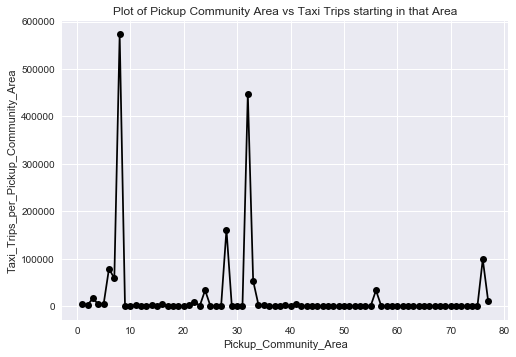

In [4]:
pickupDF
plt.plot(pickupDF['Pickup_Community_Area'],pickupDF['Taxi_Trips_per_Pickup_Community_Area'],'-ok', color='black')
plt.xlabel('Pickup_Community_Area')
plt.ylabel('Taxi_Trips_per_Pickup_Community_Area')
plt.title('Plot of Pickup Community Area vs Taxi Trips starting in that Area')


In [5]:
#dropoff community area 
query_dropoff = '''
SELECT 
    COUNT(*) AS 'Taxi_Trips_per_Dropoff_Community_Area',
    Dropoff_Community_Area
FROM
    c_taxi
GROUP BY Dropoff_Community_Area
'''
dropoffDF = getRes(query_dropoff)

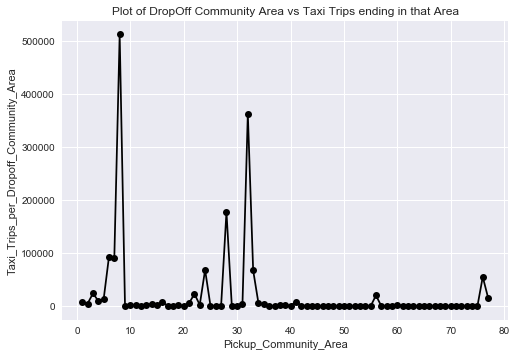

In [6]:
dropoffDF
plt.plot(dropoffDF['Dropoff_Community_Area'],dropoffDF['Taxi_Trips_per_Dropoff_Community_Area'],'-ok', color='black')
plt.xlabel('Pickup_Community_Area')
plt.ylabel('Taxi_Trips_per_Dropoff_Community_Area')
plt.title('Plot of DropOff Community Area vs Taxi Trips ending in that Area')


In [7]:
#pickup latitudes and longitudes
query_p_latlong = '''
SELECT 
    Pickup_Community_Area,
    AVG(Pickup_Centroid_Latitude) AS 'Avg_P_Lat',
    AVG(Pickup_Centroid_Longitude) AS 'Avg_P_Long'
FROM
    c_taxi
GROUP BY Pickup_Community_Area;
'''
p_latlong_DF = getRes(query_p_latlong) 

In [8]:
p_latlong_DF.head()


,Pickup_Community_Area,Avg_P_Lat,Avg_P_Long
0,1,42.009506,-87.670208
1,2,42.001556,-87.695008
2,3,41.965685,-87.655717
3,4,41.975091,-87.687479
4,5,41.947840,-87.683792


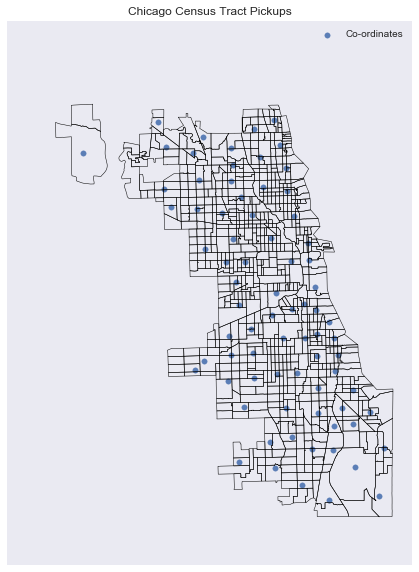

In [11]:
p_latlong_DF
pickupDF

fig = plt.figure(figsize=[16,10])
m = Basemap(projection='merc',llcrnrlat=41.60,urcrnrlat=42.10,
            llcrnrlon=-88.0,urcrnrlon=-87.50,lat_ts=20,resolution='c')
m.readshapefile('./geo_export_0e3da441-8fe8-4e11-9ca0-42ef75cab68e','chicago')

pickupLocationDF = pd.merge(pickupDF, p_latlong_DF, on='Pickup_Community_Area')
pickupLocationDF

long= []
lat = []
labelText = pickupLocationDF['Pickup_Community_Area']
for index, row in pickupLocationDF.iterrows():  
    long.append(row['Avg_P_Long'])
    lat.append(row['Avg_P_Lat'])
x,y = m(long,lat)
plt.scatter(x,y,alpha=0.9,s=30,label="Co-ordinates")
plt.title("Chicago Census Tract Pickups")
plt.legend()
plt.show()



In [12]:
#Dropoff latitudes and longitudes
query_d_latlong = '''
SELECT 
    Dropoff_Community_Area,
    AVG(Dropoff_Centroid_Latitude) AS 'Avg_D_Lat',
    AVG(Dropoff_Centroid_Longitude) AS 'Avg_D_Long'
FROM
    c_taxi
GROUP BY Dropoff_Community_Area;
'''
d_latlong_DF = getRes(query_d_latlong) 
d_latlong_DF.head()

,Dropoff_Community_Area,Avg_D_Lat,Avg_D_Long
0,1,42.009546,-87.670128
1,2,42.001545,-87.694990
2,3,41.965518,-87.655512
3,4,41.975002,-87.687406
4,5,41.947882,-87.683681


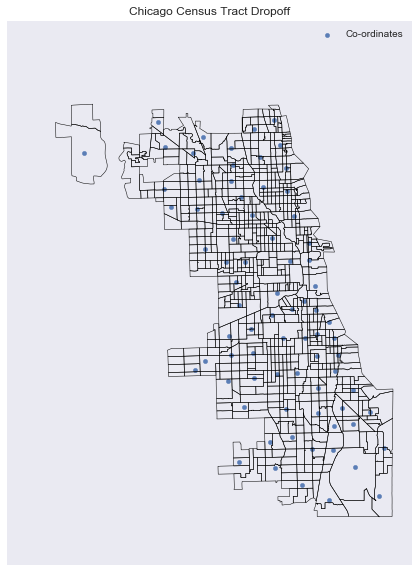

In [13]:
d_latlong_DF
dropoffDF

fig = plt.figure(figsize=[16,10])
m = Basemap(projection='merc',llcrnrlat=41.60,urcrnrlat=42.10,
            llcrnrlon=-88.0,urcrnrlon=-87.50,lat_ts=20,resolution='c')
m.readshapefile('./geo_export_0e3da441-8fe8-4e11-9ca0-42ef75cab68e','chicago')

dropoffLocationDF = pd.merge(dropoffDF, d_latlong_DF, on='Dropoff_Community_Area')
dropoffLocationDF

long= []
lat = []
labelText = dropoffLocationDF['Dropoff_Community_Area']
for index, row in dropoffLocationDF.iterrows():  
    long.append(row['Avg_D_Long'])
    lat.append(row['Avg_D_Lat'])
x,y = m(long,lat)
plt.scatter(x,y,alpha=0.9,s=20,label="Co-ordinates")
plt.title("Chicago Census Tract Dropoff")
plt.legend()
plt.show()



In [14]:
paymentType_sql ='''
SELECT 
    COUNT(1) AS 'Count', Payment_Type
FROM
    c_taxi
GROUP BY 
Payment_Type;
'''
paymenttype_Df = getRes(paymentType_sql)
paymenttype_Df

,Count,Payment_Type
0,793891,Cash
1,808907,Credit Card
2,1950,Dispute
3,14896,No Charge
4,7175,Unknown


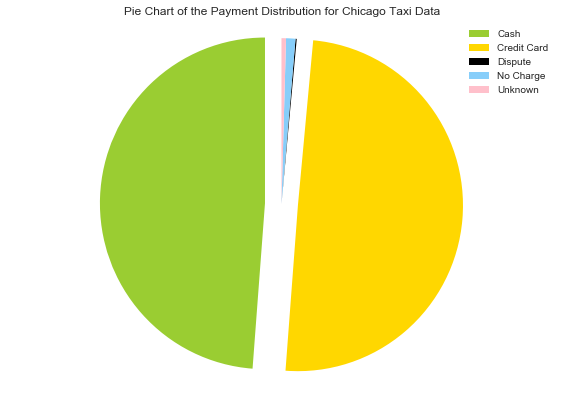

In [15]:
 
# Data to plot
labels = paymenttype_Df['Payment_Type']
sizes = paymenttype_Df['Count']
colors = ['yellowgreen', 'gold', 'black', 'lightskyblue','pink']
explode = (0.1, 0.1 , 0, 0 , 0) 
patches, texts = plt.pie(sizes, explode = explode , colors=colors, startangle=90 )
plt.legend(patches, labels)
plt.axis('equal')
plt.tight_layout()
plt.title('Pie Chart of the Payment Distribution for Chicago Taxi Data')
plt.show()


In [16]:
q_lm = '''
SELECT 
    Trip_Total, Trip_Seconds, Trip_Miles
FROM
    c_taxi;
'''
lm_DF = getRes(q_lm)
lm_DF.head()



,Trip_Total,Trip_Seconds,Trip_Miles
0,11.00,660,1.3
1,10.00,360,0.8
2,58.00,1440,15.8
3,11.75,660,1.3
4,10.00,600,1.3


In [33]:
lm_DF["Trip_Seconds"]
lm_Input = lm_DF.iloc[:,1:3] 
lm_Input.head()

,Trip_Seconds,Trip_Miles
0,660,1.3
1,360,0.8
2,1440,15.8
3,660,1.3
4,600,1.3


In [28]:
regr = LinearRegression()
regr.fit(lm_Input,lm_DF['Trip_Total'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [43]:
regr.coef_ 
regr.intercept_
print("The Equation is :\n",regr.intercept_ ,"+" , regr.coef_[0],"*",lm_Input.columns[0],"+",regr.coef_[1],"*",lm_Input.columns[1])



The Equation is :
 1.92432688835 + 0.0118580388249 * Trip_Seconds + 1.29507985744 * Trip_Miles


In [12]:
db.close()